In [2]:
import numpy as np
from Bio import SeqIO
import os
import pandas as pd
import torch
import seaborn as sns
import math
import scipy.stats as stats
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from numpy import trapz
from sklearn.metrics import auc
from pathlib import Path

sns.set(font_scale=1.8, style="ticks")

In [17]:
runs_folder = Path("../../../runs")
data_folder = Path("../../../data/gisaid/flu/ha_processed_continents")
saving_dir = Path("figs")

saving_dir.mkdir(parents=True, exist_ok=True)

In [18]:
subtype = "a_h3n2"
continents = ("north_america", "africa", "south_america", "asia", "europe", "oceania")

def get_nlls(df):
    m = df.pivot(index='src_id', columns='src_time', values='prediction')
    m = torch.tensor(m.to_numpy())
    
    nlls = - (torch.logsumexp(-m, dim=-1) - math.log(m.size(1))) 
    
    token_num = torch.tensor(df.pivot(index='src_id', columns='src_time', values='token_num').to_numpy())
    token_num = torch.mean(token_num.float(), dim=1)

    freqs = torch.tensor(df.pivot(index='src_id', columns='src_time', values='freq').to_numpy())
    if torch.all(torch.isnan(freqs)):
        freqs = torch.ones(freqs.size()) / freqs.size(0)
        
    freqs = torch.mean(freqs, dim=1)
    nll = torch.sum((freqs * nlls)) / torch.sum(freqs * token_num)
    return nll, sum(nlls)

nll_results = defaultdict(list)

testing_years = list(range(2015, 2019))

for rev_nll_model_seed in ("1005", "529", "1213"):
    print(">>> seed", rev_nll_model_seed)

    for year in testing_years:
        print(year)
        location2bin_size = dict()
        for continent in continents:
            index = (year - 2018) * 2 + 30
            virus_fasta_path=data_folder / ("2003-10_to_2023-04_6M/a_h3n2/continents/human_minBinSize10_minLen553_%s_location_bins/%d.fasta" % (continent, index))
            if not os.path.exists(virus_fasta_path):
                continue
            records = SeqIO.parse(virus_fasta_path, "fasta")
            for record in records:
                description = record.description.split()[1]
                bin_size = int({x.split("=")[0]: x.split("=")[1] for x in description.split("|")}["bin_size"])
            location2bin_size[continent] = bin_size

        for temperature in (0.2, 0.4, 0.6, 0.8, 1.0):
            for continent in continents:

                name2nll_path = {
                    "Global": runs_folder / ("flu_ah3n2_continents/2003-10_to_%d-02_2M/global/test/%s/temp_%.1lf/test_results.csv" % (year, continent, temperature)),
                    "Prepend": runs_folder / ("flu_ah3n2_continents/2003-10_to_%d-02_2M/prepend/test/%s/temp_%.1lf/test_results.csv" % (year, continent, temperature)),
                    "Add_Embed": runs_folder / ("flu_ah3n2_continents/2003-10_to_%d-02_2M/concat/test/%s/temp_%.1lf/test_results.csv" % (year, continent, temperature)),
                    "Param_share": runs_folder / ("flu_ah3n2_continents/2003-10_to_%d-02_2M/param_share/test/%s/temp_%.1lf/test_results.csv" % (year, continent, temperature)),
                    "LoRA": runs_folder / ("flu_ah3n2_continents/2003-10_to_%d-02_2M/finetune_lora/test/%s/temp_%.1lf/test_results.csv" % (year, continent, temperature)),
                    "Finetune": runs_folder / ("flu_ah3n2_continents/2003-10_to_%d-02_2M/finetune/test/%s/temp_%.1lf/test_results.csv" % (year, continent, temperature)),
                    # "Transmission": runs_folder / "flu_ah3n2_continents/2003-10_to_%d-02_2M/transmission/test/%s/temp_%.1lf/test_results.csv" % (year, continent, temperature),
                    "Transmission": runs_folder / ("flu_ah3n2_continents/2003-10_to_%d-02_2M/transmission/test/%s/temp_%.1lf/lightning_logs/version_0/test_results.csv" % (year, continent, temperature)),
                }

                name2rev_nll_path = {                    
                    "Transmission": runs_folder / ("flu_ah3n2_continents/2003-10_to_%d-02_2M/transmission/test_rev_seed%s/%s/temp_%.1lf/lightning_logs/version_0/test_results.csv" % (year, rev_nll_model_seed, continent, temperature)),
                    "Global": runs_folder / ("flu_ah3n2_continents/2003-10_to_%d-02_2M/global/test_rev_seed%s/%s/temp_%.1lf/lightning_logs/version_0/test_results.csv" % (year, rev_nll_model_seed, continent, temperature)),
                    "Prepend": runs_folder / ("flu_ah3n2_continents/2003-10_to_%d-02_2M/prepend/test_rev_seed%s/%s/temp_%.1lf/lightning_logs/version_0/test_results.csv" % (year, rev_nll_model_seed, continent, temperature)),
                    "Add_Embed": runs_folder / ("flu_ah3n2_continents/2003-10_to_%d-02_2M/concat/test_rev_seed%s/%s/temp_%.1lf/lightning_logs/version_0/test_results.csv" % (year, rev_nll_model_seed, continent, temperature)),
                    "Finetune": runs_folder / ("flu_ah3n2_continents/2003-10_to_%d-02_2M/finetune/test_rev_seed%s/%s/temp_%.1lf/lightning_logs/version_0/test_results.csv" % (year, rev_nll_model_seed, continent, temperature)),
                    "Param_share": runs_folder / ("flu_ah3n2_continents/2003-10_to_%d-02_2M/param_share/test_rev_seed%s/%s/temp_%.1lf/lightning_logs/version_0/test_results.csv" % (year, rev_nll_model_seed, continent, temperature)),
                    "LoRA": runs_folder / ("flu_ah3n2_continents/2003-10_to_%d-02_2M/finetune_lora/test_rev_seed%s/%s/temp_%.1lf/lightning_logs/version_0/test_results.csv" % (year, rev_nll_model_seed, continent, temperature)),
                }

                for name, _path in name2nll_path.items():
                    our_model_path_nll = name2nll_path[name]
                    our_model_path_rev_nll = name2rev_nll_path[name]

                    if os.path.exists(our_model_path_rev_nll) and os.path.exists(our_model_path_nll):
                        df = pd.read_csv(our_model_path_nll)
                        nll, sum_nll = get_nlls(df)
                        df = pd.read_csv(our_model_path_rev_nll)
                        rev_nll, sum_rev_nll = get_nlls(df)

                        nll_results["NLL"].append(nll.item())
                        nll_results["Year"].append(year)
                        nll_results["reverse NLL"].append(rev_nll.item())
                        nll_results["temperature"].append(temperature)
                        nll_results["continent"].append(continent)
                        nll_results["model"].append(name)
                        nll_results["bin_size"].append(location2bin_size[continent])
                        nll_results["oracle"].append(rev_nll_model_seed)

                    else:
                        if not os.path.exists(our_model_path_rev_nll):
                            print("path doesn't exist", our_model_path_rev_nll)

                        if not os.path.exists(our_model_path_nll):
                            print("path doesn't exist", our_model_path_nll)

nll_results = pd.DataFrame(nll_results)
print(nll_results)


>>> seed 1005
2015
2016
2017
2018
>>> seed 529
2015
2016
2017
2018
>>> seed 1213
2015
2016
2017
2018
           NLL  Year  reverse NLL  temperature      continent         model  \
0     0.153713  2015     0.004832          0.2  north_america        Global   
1     0.154744  2015     0.004893          0.2  north_america       Prepend   
2     0.167052  2015     0.004855          0.2  north_america     Add_Embed   
3     0.159617  2015     0.047765          0.2  north_america   Param_share   
4     0.155476  2015     0.004826          0.2  north_america          LoRA   
...        ...   ...          ...          ...            ...           ...   
2515  0.056597  2018     0.025494          1.0        oceania     Add_Embed   
2516  0.059234  2018     0.029156          1.0        oceania   Param_share   
2517  0.046068  2018     0.039530          1.0        oceania          LoRA   
2518  0.053191  2018     0.024242          1.0        oceania      Finetune   
2519  0.055993  2018     0.023

In [19]:
def get_summary(df, keys=("model", "temperature", "year"), weighted_average=True, nll_key="NLL", rev_nll_key="reverse NLL"):
    summary_nll_results = defaultdict(list)
    for x in zip(*(df[key] for key in keys)):
        _df = df
        for i, key in enumerate(keys):
            _df = _df[_df[key] == x[i]]
        
        if weighted_average:
            ave_nll = np.sum(_df["bin_size"] * _df[nll_key]) / np.sum(_df["bin_size"])
            ave_rev_nll = np.sum(_df["bin_size"] * _df[rev_nll_key]) / np.sum(_df["bin_size"])
        else:
            ave_nll = np.mean(_df[nll_key])
            ave_rev_nll = np.mean(_df[rev_nll_key])
        
        for i, key in enumerate(keys):
            summary_nll_results[key].append(x[i])
        summary_nll_results[nll_key].append(ave_nll)
        summary_nll_results[rev_nll_key].append(ave_rev_nll)
        summary_nll_results["toal_sample_size"].append(np.sum(_df["bin_size"]))

    summary_nll_results = pd.DataFrame(summary_nll_results)
    summary_nll_results = summary_nll_results.drop_duplicates()
    return summary_nll_results

In [20]:
def plot(summary_summary_df, fig_title, fig_save_path, hide_legend=False):
    plt.xscale('log')
    plt.yscale('log')

    plt.rcParams['lines.markersize'] = 15

    models = list(set(summary_summary_df["model"]))
    models.sort()
    style_dict = {}
    for model in models:
        if model == "Transmission":
            style_dict[model] = ""
        else:
            style_dict[model] = (2,2)

    style_order = models
    style_order.remove("Transmission")
    style_order = ["Transmission"] + style_order

    style_order =  ['Transmission', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']

    palette_light = sns.color_palette("Set2", n_colors=8)
    palette_dark = sns.color_palette("hls", n_colors=8)
    color_dict = {}
    for i, model in enumerate(models):
        color_dict[model] = palette_light[i]
    color_dict["Transmission"] = palette_dark[5]
    
    ax = sns.lineplot(summary_summary_df, x="NLL", y="reverse NLL", hue="model", markers=True, # marker='o', 
                      sort=False,style="model",lw=2.5, dashes=style_dict,palette=color_dict,style_order=style_order) # , size=20 ,linewidth = 1.5

    ax.set_title(fig_title)

    if hide_legend:
        plt.legend([],[], frameon=False)
    else:
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

    plt.savefig(fig_save_path, format='pdf', bbox_inches='tight')

    plt.show()

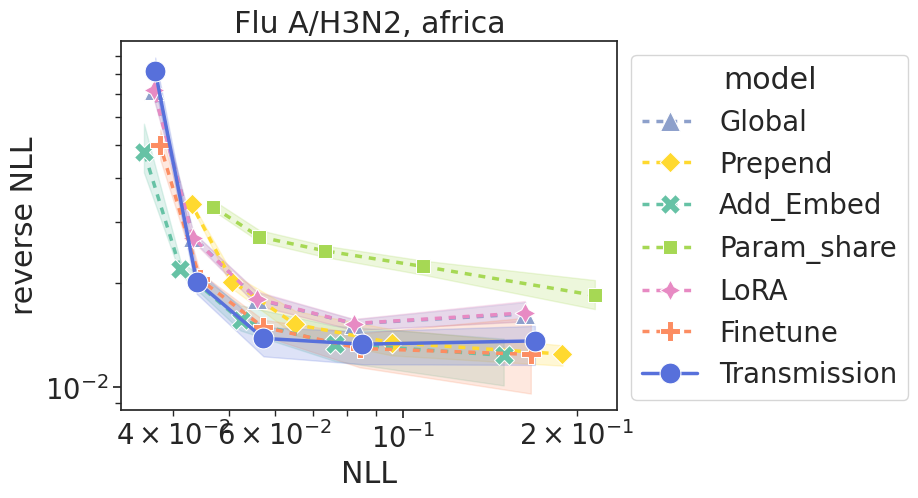

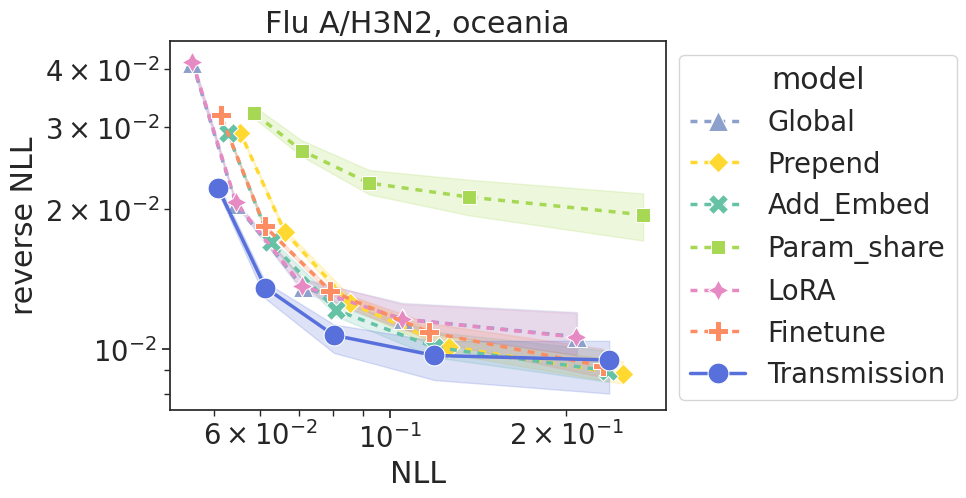

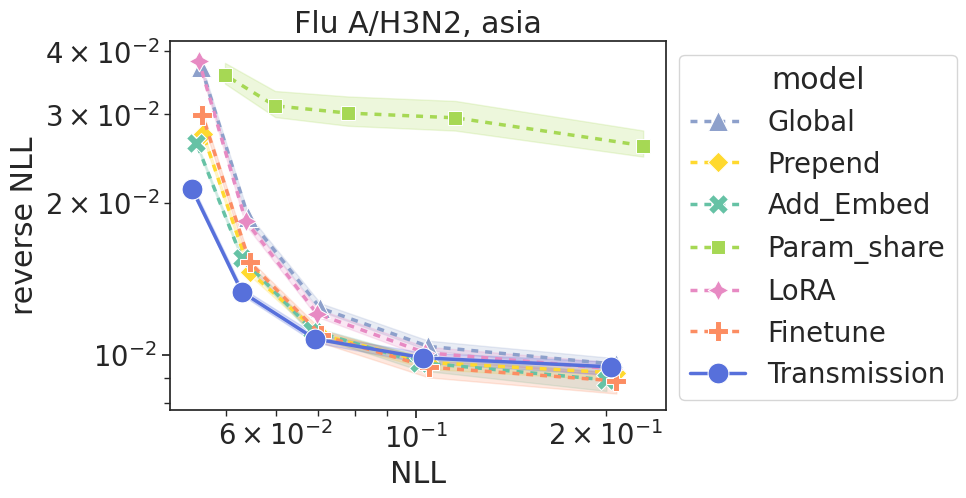

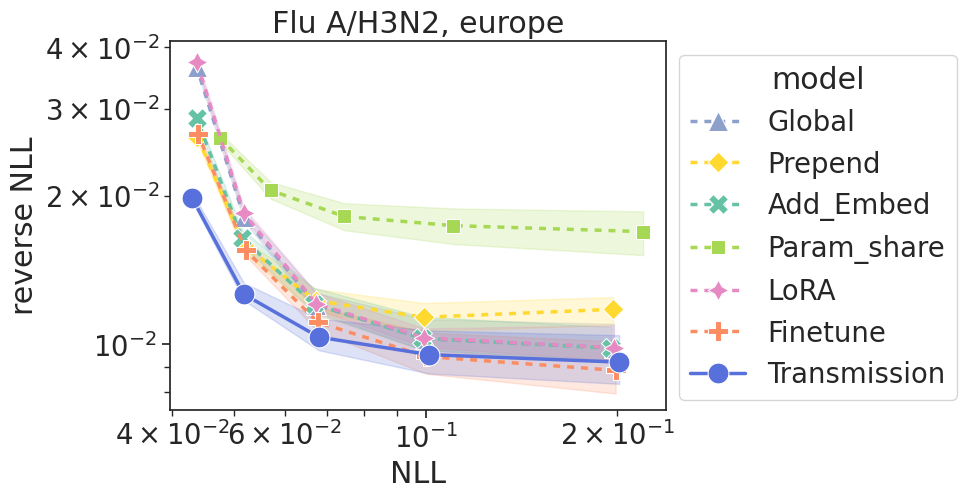

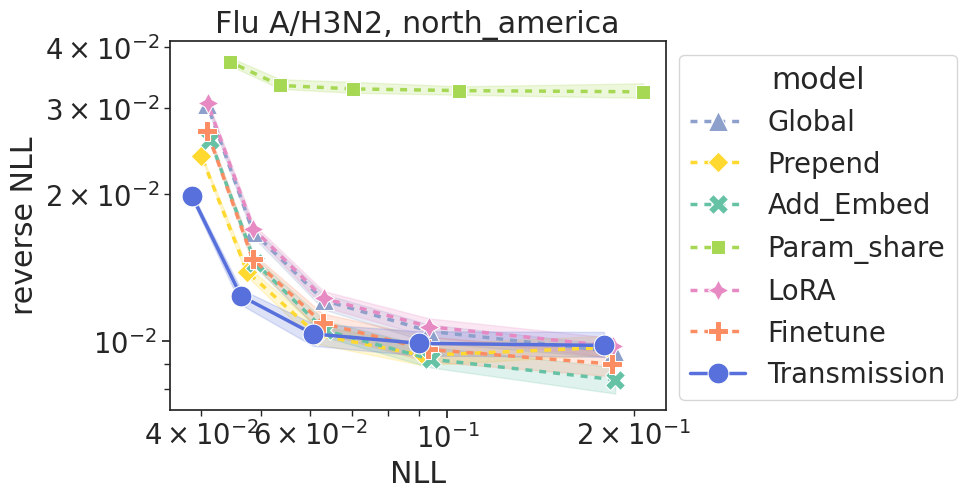

In [21]:
min_bin_size = 200

_nll_results = nll_results[nll_results["bin_size"] >= min_bin_size]
local_summary_df = get_summary(_nll_results, keys=("model", "temperature", "continent", "oracle"))

sorted_locations = sorted(dict(zip(local_summary_df["continent"], local_summary_df["toal_sample_size"])).items(), key=lambda x: x[1])

for location, ss in sorted_locations:    
    local_df = local_summary_df[local_summary_df["continent"] == location]
    if len(local_df) <= 0:
        continue    
    plot(local_df, "Flu %s, %s" % (subtype.upper().replace("_", "/"), location), 
         saving_dir / ("flu_continent_%s.pdf" % location))
    

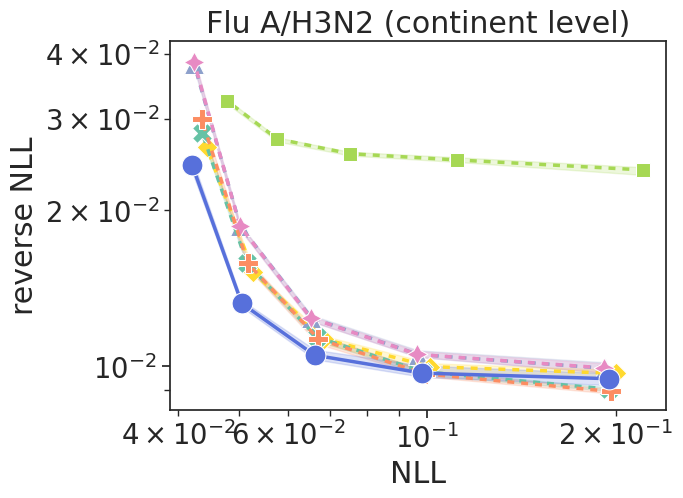

In [27]:
plt.xscale('log')
plt.yscale('log')

_nll_results = nll_results[nll_results["bin_size"] >= min_bin_size]

summary_summary_df = get_summary(_nll_results, keys=("model", "temperature","oracle"), weighted_average=False)

plt.rcParams['lines.markersize'] = 15

models = list(set(summary_summary_df["model"]))
models.sort()
style_dict = {}
for model in models:
    if model == "Transmission":
        style_dict[model] = ""
    else:
        style_dict[model] = (2,2)
        
style_order =  ['Transmission', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']

palette_light = sns.color_palette("Set2", n_colors=8) # pastel
palette_dark = sns.color_palette("hls", n_colors=8)
color_dict = {}
for i, model in enumerate(models):
    color_dict[model] = palette_light[i]
color_dict["Transmission"] = palette_dark[5]

ax = sns.lineplot(summary_summary_df, x="NLL", y="reverse NLL", hue="model", markers=True,
                  sort=False,style="model",lw=2.5, dashes=style_dict,palette=color_dict,style_order=style_order)

ax.set_title("Flu %s (continent level)" % (subtype.upper().replace("_", "/")))

plt.legend([],[], frameon=False)

# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.savefig(saving_dir / "main_res_flu_continent_average.pdf", format='pdf', bbox_inches='tight')


plt.show()

In [29]:
# _nll_results = nll_results[nll_results["bin_size"] >= min_bin_size]

# summary_summary_df = get_summary(_nll_results, keys=("model", "temperature","oracle", "continent"), weighted_average=False)

# def get_worset_location(df, key="NLL", temp=1.0):
#     _df = df[df["temperature"] == temp]
#     loc2nlls = defaultdict(list)
#     for loc, nll in zip(_df["continent"], _df[key]):
#         loc2nlls[loc].append(nll)
#     for loc in loc2nlls:
#         assert len(loc2nlls[loc]) == 3
#     loc2nlls = {k: np.mean(v) for k, v in loc2nlls.items()}
#     return sorted(loc2nlls.items(), key=lambda x: x[1], reverse=True)[0]
    

# new_df = []
# for model in ['Global', 'Prepend', 'Add_Embed', 'Param_share', 'LoRA', 'Finetune', 'Transmission']:
#     _df = summary_summary_df[summary_summary_df["model"] == model]
#     location = get_worset_location(_df)[0]
#     _df = _df[_df["continent"] == location]
#     new_df.append(_df)

# new_df = pd.concat(new_df)

# plot(new_df, "Flu %s (continent level)" % (subtype.upper().replace("_", "/")), 
#          saving_dir / "main_res_flu_continent_worse.pdf", hide_legend=True)



# Output the numbers (Appendix Table 8)

In [28]:

def calculate_ci(data):
    # Calculate sample mean and standard deviation
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)
    n = len(data)

    # Calculate the 95% confidence interval
    confidence = 0.95
    alpha = 1 - confidence

    # For large samples, use z-distribution
    z_critical = stats.norm.ppf(1 - alpha / 2)

    # For small samples, use t-distribution
#     t_critical = stats.t.ppf(1 - alpha / 2, df=n-1) # Uncomment for small samples

    # Margin of error
    margin_of_error = z_critical * (std_dev / np.sqrt(n))
#     margin_of_error = t_critical * (std_dev / np.sqrt(n)) # Uncomment for small samples

    # Confidence interval
    ci_lower = mean - margin_of_error
    ci_upper = mean + margin_of_error
        
    return mean, ci_lower, ci_upper
    

def print_markdown_table(df, temp, group_by=("model",), values=("reverse NLL", 'NLL')):
    res_dict = dict()
    for i, row in df.iterrows():
        key = tuple(row[x] for x in group_by)
        if key not in res_dict:
            res_dict[key] = defaultdict(list)
        for value in values:
            res_dict[key][value].append(row[value])    
    
    new_table = []
    rev_nll_cis = dict()
    for key in res_dict:
        ci = calculate_ci(res_dict[key]["reverse NLL"])
        new_table.append(
            { 'model': key[0], 'NLL': res_dict[key]["NLL"][0], "reverse NLL": ci[0], 'ci_lower': ci[1], 'ci_upper': ci[2]}
        )
        model_name = key[0].replace('_', '\\_')
        if model_name == "Transmission":
            model_name = "{\\bf Transmission}"
        x = f"{model_name} & {temperature} &  {res_dict[key]['NLL'][0]:.4f} & {ci[0]:.4f} ({ci[1]:.4f}, {ci[2]:.4f}) \\\\"
        print(x)    
    
    df = pd.DataFrame(new_table)        
    return res_dict, rev_nll_cis

for temperature in (0.2, 0.4, 0.6, 0.8, 1.0):
    _, table = print_markdown_table(summary_summary_df[summary_summary_df["temperature"] == temperature], temperature)
    print("\midrule")

Global & 0.2 &  0.1921 & 0.0099 (0.0096, 0.0102) \\
Prepend & 0.2 &  0.2003 & 0.0097 (0.0095, 0.0099) \\
Add\_Embed & 0.2 &  0.1951 & 0.0090 (0.0089, 0.0091) \\
Param\_share & 0.2 &  0.2210 & 0.0239 (0.0234, 0.0244) \\
LoRA & 0.2 &  0.1914 & 0.0099 (0.0097, 0.0101) \\
Finetune & 0.2 &  0.1964 & 0.0089 (0.0088, 0.0091) \\
{\bf Transmission} & 0.2 &  0.1951 & 0.0095 (0.0091, 0.0099) \\
\midrule
Global & 0.4 &  0.0967 & 0.0105 (0.0103, 0.0107) \\
Prepend & 0.4 &  0.1010 & 0.0100 (0.0097, 0.0102) \\
Add\_Embed & 0.4 &  0.0984 & 0.0098 (0.0096, 0.0099) \\
Param\_share & 0.4 &  0.1113 & 0.0250 (0.0247, 0.0253) \\
LoRA & 0.4 &  0.0964 & 0.0105 (0.0104, 0.0107) \\
Finetune & 0.4 &  0.0990 & 0.0097 (0.0095, 0.0098) \\
{\bf Transmission} & 0.4 &  0.0981 & 0.0097 (0.0094, 0.0100) \\
\midrule
Global & 0.6 &  0.0653 & 0.0124 (0.0122, 0.0126) \\
Prepend & 0.6 &  0.0684 & 0.0113 (0.0110, 0.0115) \\
Add\_Embed & 0.6 &  0.0666 & 0.0114 (0.0112, 0.0115) \\
Param\_share & 0.6 &  0.0752 & 0.0257 (0.0254, 